In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

from dogo.results import get_pred_means_and_vars, get_experiment_details

In [3]:
plt.rc('font', size=16)

In [4]:
STATE_DIMS = 17
ACTION_DIMS = 6
REWARD_DIMS = 1
TERMINAL_DIMS = 1

DIMS = [STATE_DIMS, ACTION_DIMS, STATE_DIMS, REWARD_DIMS, TERMINAL_DIMS]
ENDS = np.cumsum(DIMS)

In [37]:
evaluation_datasets = [
    "D3RLPY-MP4-P0_100000",
    "D3RLPY-MP4-P1_100000",
    "D3RLPY-MP4-P2_100000",
    "D3RLPY-MP4-P3_100000",
    "D3RLPY-MP4-P4_100000",
    # "D3RLPY-MP5-P0_100000",
    # "D3RLPY-MP5-P1_20000",
    # "D3RLPY-MP5-P1_100000",
    # "D3RLPY-MP5-P2_100000",
    # "D3RLPY-MP5-P3_100000",
    # "D3RLPY-MP5-P4_100000",
    # "D3RLPY-MP6-P0_100000",
    # "D3RLPY-MP6-P1_100000",
    # "D3RLPY-MP6-P2_100000",
    # "D3RLPY-MP6-P3_100000",
    # "D3RLPY-MP6-P4_100000",
    # "D3RLPY-PAP8-P0_20000",
    # "D3RLPY-PAP8-P1_20000",
    # "D3RLPY-PAP8-P2_20000",
    # "D3RLPY-PAP8-P3_20000",
    # "D3RLPY-PAP8-P4_20000",
    "D3RLPY-PAP8-P0_100000",
    "D3RLPY-PAP8-P1_100000",
    "D3RLPY-PAP8-P2_100000",
    "D3RLPY-PAP8-P3_100000",
    "D3RLPY-PAP8-P4_100000",
    # "D3RLPY-PAP9-P0_20000",
    # "D3RLPY-PAP9-P0_100000",
    # "D3RLPY-PAP9-P1_100000",
    # "D3RLPY-PAP9-P2_100000",
    # "D3RLPY-PAP9-P3_100000",
    # "D3RLPY-PAP9-P4_100000",
    # "D3RLPY-PAP10-P0_100000",
    # "D3RLPY-PAP10-P1_100000",
    # "D3RLPY-PAP10-P2_100000",
    # "D3RLPY-PAP10-P3_100000",
    # "D3RLPY-PAP10-P4_100000",
    "RAND-1",
    "RAND-2",
    "RAND-3",
    "RAND-4",
    "RAND-5",
    # "RAND-6",
    # "RAND-7",
    # "RAND-8",
    # "RAND-9",
    # "RAND-10",
    # "RAND-D3RLPY-MP4-P0-1_100000",
    # "RAND-D3RLPY-MP4-P1-1_100000",
    # "RAND-D3RLPY-MP4-P2-1_100000",
    # "RAND-D3RLPY-MP4-P3-1_100000",
    # "RAND-D3RLPY-MP4-P4-1_100000",
    # "RAND-D3RLPY-PAP8-P0-1_100000",
    # "RAND-D3RLPY-PAP8-P1-1_100000",
    # "RAND-D3RLPY-PAP8-P2-1_100000",
    # "RAND-D3RLPY-PAP8-P3-1_100000",
    # "RAND-D3RLPY-PAP8-P4-1_100000",
]
training_datasets = [
    'MIXED-3',
]
training_experiments = [
    "MP329",
    "MP330",
    "MP331",
    "MP332",
    "MP333",
    "MP334",
    "MP335",
    "MP336",
    "MP337",
    "MP338",
    "MP339",
    "MP340",
]

In [16]:
preds = {}
pred_summary = {}
for exp in training_experiments:
    preds[exp] = {}
    
    exp_details = get_experiment_details(exp, get_elites=True)
    elites = exp_details.elites
    key = ' - '.join((exp_details.name, exp_details.dataset, f'REx: {exp_details.rex}'))
    for data in evaluation_datasets:
        pred_means, pred_vars = get_pred_means_and_vars(exp, data)

        preds[exp][data] = {
            'pred_means': pred_means[elites, :, :],
            'pred_vars': pred_vars[elites, :, :],
        }

        pred_summary[(key, data)] = {
            'experiment': exp_details.name,
            'rex': exp_details.rex,
            'rex_beta': exp_details.rex_beta or 0.,
            'training_dataset': exp_details.dataset,
            'seed': exp_details.seed,
            'mean_pred_means': pred_means.mean(),
            'mean_pred_vars': pred_vars.mean(),
            'median_pred_means': np.percentile(pred_means, 50),
            'median_pred_vars': np.percentile(pred_vars, 50)
        }


In [20]:
pred_summary_df = (
    pd.DataFrame().from_dict(pred_summary, orient='index').
    reset_index().rename(columns={'level_0': 'key', 'level_1': 'evaluation_dataset'})
)

In [21]:
preds_groups = (
    pred_summary_df[['rex', 'rex_beta', 'training_dataset', 'evaluation_dataset', 'seed', 'mean_pred_means', 'mean_pred_vars', 'median_pred_means', 'median_pred_vars']].
    groupby(['rex', 'rex_beta', 'training_dataset', 'evaluation_dataset'])
    # groupby(['rex', 'training_dataset', 'evaluation_dataset'])
)
preds_avgs_df  = preds_groups.mean().reset_index()
preds_stds_df  = preds_groups.std().reset_index().replace(np.NaN, 0)
preds_mins_df  = preds_groups.min().reset_index().replace(np.NaN, 0)
preds_maxes_df = preds_groups.max().reset_index().replace(np.NaN, 0)

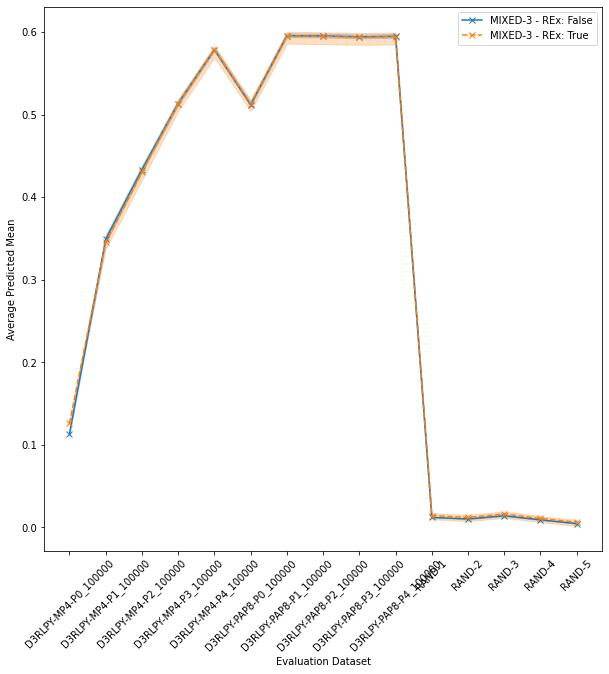

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

metric = 'mean_pred_means'
for t_ds in training_datasets:
    for rex, rex_beta in [(False, 10.), (True, 10.)]:
        mask = (
            (preds_avgs_df['training_dataset'] == t_ds) &
            (preds_avgs_df['rex'] == rex) &
            (preds_avgs_df['rex_beta'] == rex_beta) &
            # (preds_avgs_df['seed'] == 4321) &
            (preds_avgs_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
        )
        plot_means = preds_avgs_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_mins = preds_mins_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_maxes = preds_maxes_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        label = f'{t_ds} - REx: {rex}'
        p = ax.plot(evaluation_datasets, plot_means, label=label, marker='x', ls='--' if rex else '-')
        ax.fill_between(evaluation_datasets, plot_mins, plot_maxes, color=p[0].get_color(), alpha=0.25)
ax.set_xticks(ax.get_xticks(), evaluation_datasets, rotation=45)
ax.set_xlabel('Evaluation Dataset')
ax.set_ylabel('Average Predicted Mean')
ax.legend()

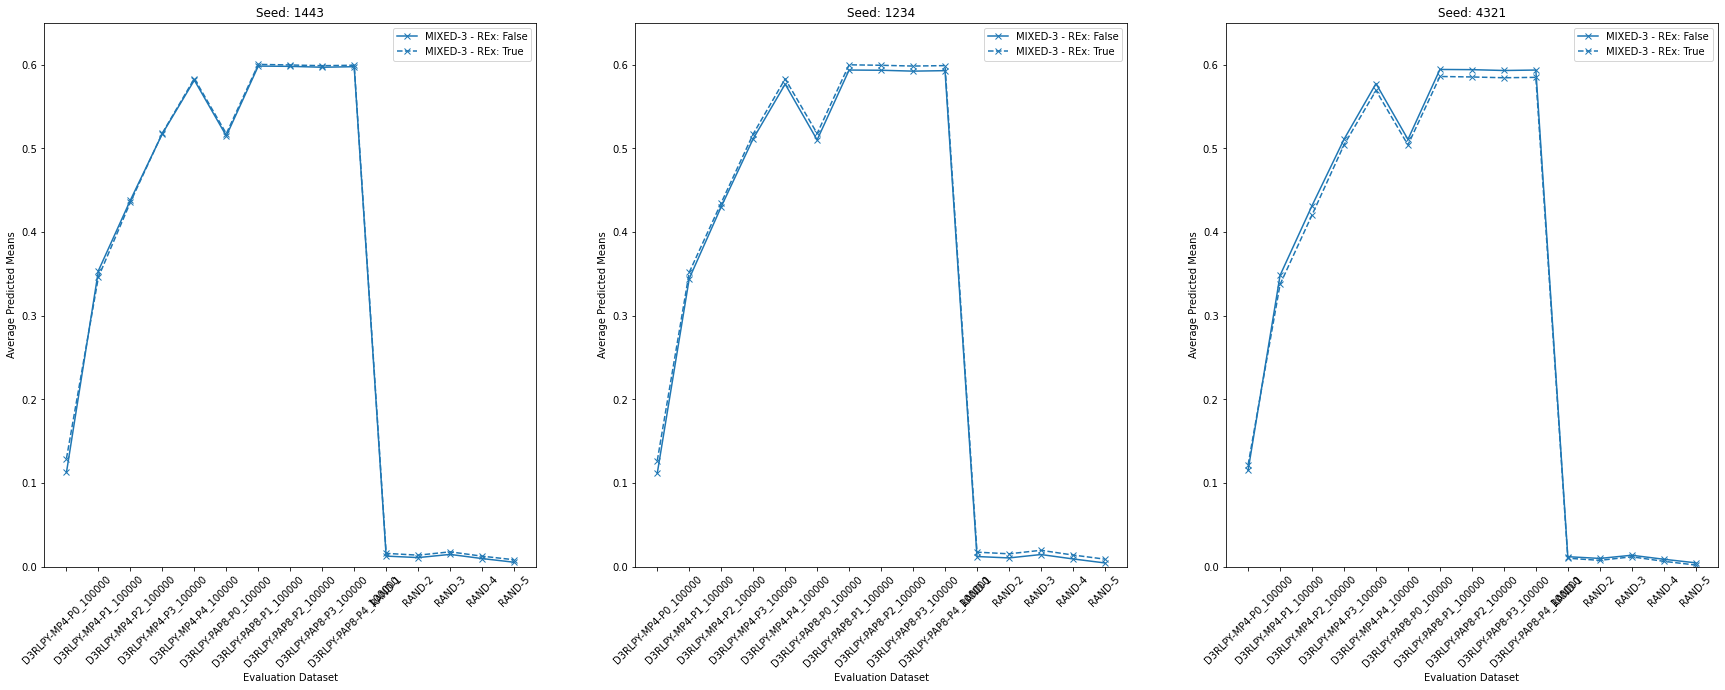

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

metric = 'mean_pred_means'
for i, seed in enumerate([1443, 1234, 4321]):
    for t_ds in training_datasets:
        for rex, rex_beta in [(False, 10.), (True, 10.)]:
            mask = (
                (pred_summary_df['training_dataset'] == t_ds) &
                (pred_summary_df['rex'] == rex) &
                (pred_summary_df['rex_beta'] == rex_beta) &
                (pred_summary_df['seed'] == seed) &
                (pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - REx: {rex}'
            p = ax[i].plot(evaluation_datasets, plot_vals, label=label, marker='x', ls='--' if rex else '-', c=p[0].get_color() if rex else None)
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=45)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Average Predicted Means')
    ax[i].set_ylim(0., 0.65)
    ax[i].legend()

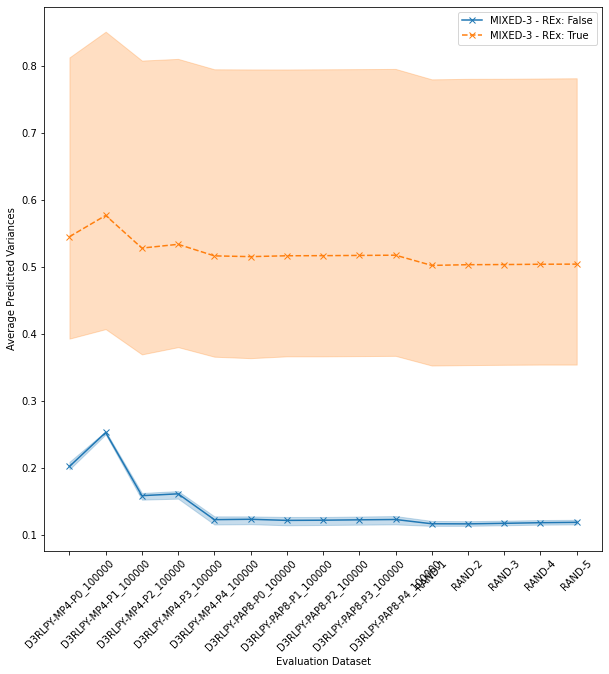

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

metric = 'mean_pred_vars'
for t_ds in training_datasets:
    for rex, rex_beta in [(False, 10.), (True, 10.)]:
        mask = (
            (preds_avgs_df['training_dataset'] == t_ds) &
            (preds_avgs_df['rex'] == rex) &
            (preds_avgs_df['rex_beta'] == rex_beta) &
            # (preds_avgs_df['seed'] == 4321) &
            (preds_avgs_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
        )
        plot_means = preds_avgs_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_mins = preds_mins_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_maxes = preds_maxes_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        label = f'{t_ds} - REx: {rex}'
        p = ax.plot(evaluation_datasets, plot_means, label=label, marker='x', ls='--' if rex else '-')
        ax.fill_between(evaluation_datasets, plot_mins, plot_maxes, color=p[0].get_color(), alpha=0.25)
ax.set_xticks(ax.get_xticks(), evaluation_datasets, rotation=45)
ax.set_xlabel('Evaluation Dataset')
ax.set_ylabel('Average Predicted Variances')
ax.legend()

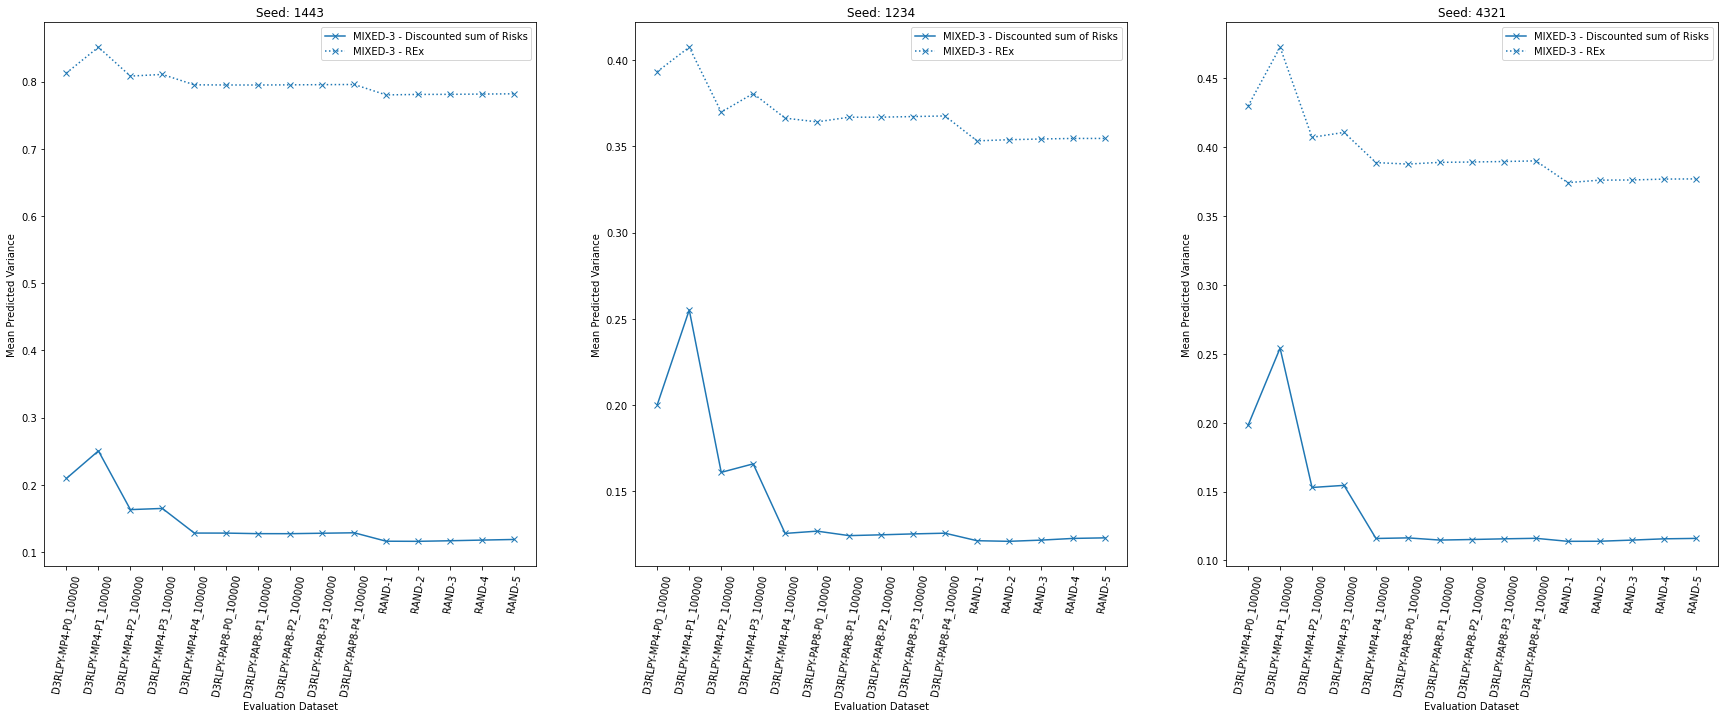

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

cols = [u'#1f77b4', u'#ff7f0e']
lss =  ['-', ':', '--']
labels = ['Discounted sum of Risks', 'REx']

metric = 'mean_pred_vars'
for i, seed in enumerate([1443, 1234, 4321]):
    for j, t_ds in enumerate(training_datasets):
        for k, (rex, rex_beta) in enumerate([(False, 10.), (True, 10.)]):
            mask = (
                (pred_summary_df['training_dataset'] == t_ds) &
                (pred_summary_df['rex'] == rex) &
                (pred_summary_df['rex_beta'] == rex_beta) &
                (pred_summary_df['seed'] == seed) &
                (pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - {labels[k]}'
            p = ax[i].plot(
                evaluation_datasets, plot_vals, label=label, marker='x',
                ls=lss[k],
                c=cols[j]
            )
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=80)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Mean Predicted Variance')
    # ax[i].set_ylim(0, 0.2)
    ax[i].legend()

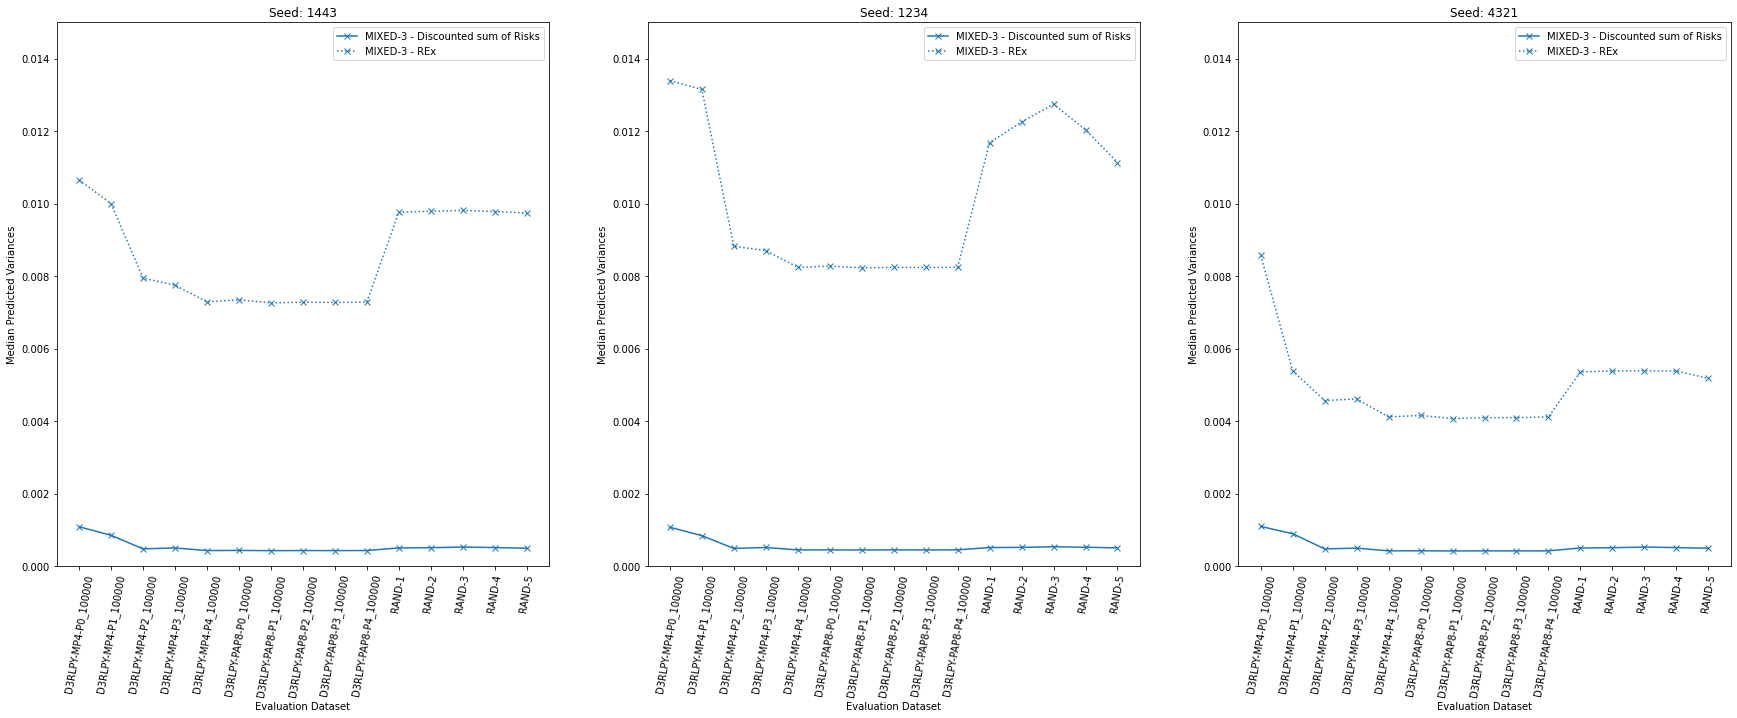

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

cols = [u'#1f77b4', u'#ff7f0e']
lss =  ['-', ':', '--']
labels = ['Discounted sum of Risks', 'REx']

metric = 'median_pred_vars'
for i, seed in enumerate([1443, 1234, 4321]):
    for j, t_ds in enumerate(training_datasets):
        for k, (rex, rex_beta) in enumerate([(False, 10.), (True, 10.)]):
            mask = (
                (pred_summary_df['training_dataset'] == t_ds) &
                (pred_summary_df['rex'] == rex) &
                (pred_summary_df['rex_beta'] == rex_beta) &
                (pred_summary_df['seed'] == seed) &
                (pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - {labels[k]}'
            p = ax[i].plot(
                evaluation_datasets, plot_vals, label=label, marker='x',
                ls=lss[k],
                c=cols[j]
            )
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=80)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Median Predicted Variances')
    ax[i].set_ylim(0.000, 0.015)
    ax[i].legend()

In [73]:
exp_1 = 'MP330'
exp_2 = 'MP339'
val_arr, experiment_arr, dataset_arr = np.array([]), np.array([]), np.array([])
for data in evaluation_datasets:
    vals_1 = preds[exp_1][data]['pred_vars'].mean(axis=0).flatten()
    vals_2 = preds[exp_2][data]['pred_vars'].mean(axis=0).flatten()

    val_arr = np.hstack((val_arr, np.log(vals_1), np.log(vals_2)))
    experiment_arr = np.hstack((experiment_arr, np.full(len(vals_1), exp_1), np.full(len(vals_2), exp_2)))
    dataset_arr = np.hstack((dataset_arr, np.full(len(vals_1), data), np.full(len(vals_2), data)))

In [74]:
vals_df = pd.DataFrame({
    'values': val_arr,
    'experiment': experiment_arr,
    'dataset': dataset_arr,
})

Text(0, 0.5, 'Log Variance')

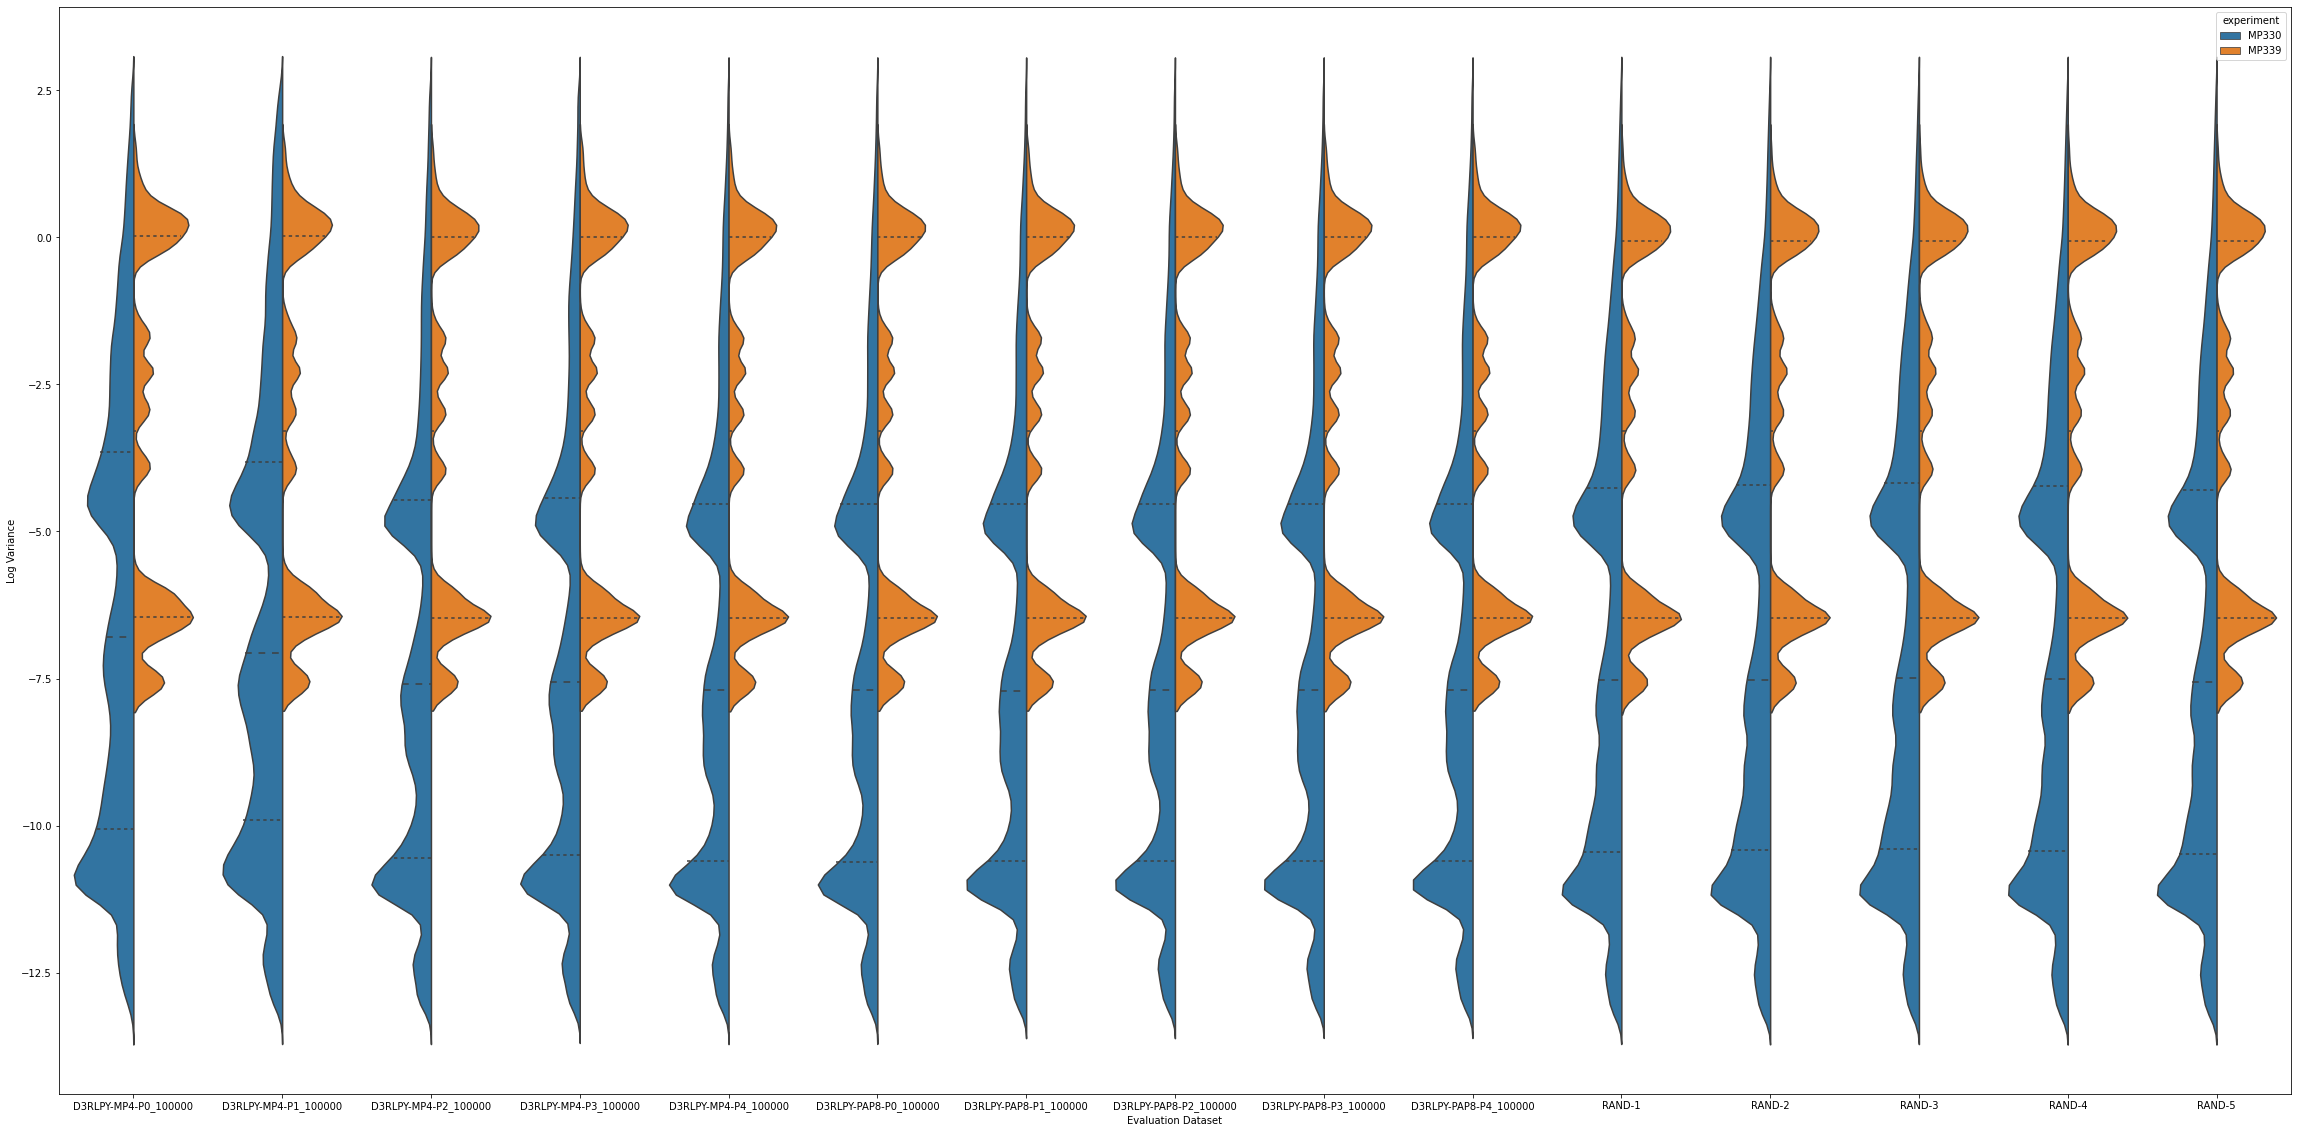

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(40,20))
sns.violinplot(
    x='dataset', y='values', hue='experiment', data=vals_df, split=True, scale="count", inner="quartile"
)
ax.set_xlabel('Evaluation Dataset')
ax.set_ylabel('Log Variance')